In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.model_selection import TimeSeriesSplit

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [32]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

seed(10)
tf.random.set_seed(10)

In [33]:
df= pd.read_csv("AQI_Signature.csv", sep=";")
df2=pd.read_csv("AQI_Signature_val.csv", sep=";")
df.head()

,name,time,device,mileage,s_00,s_01,s_02,s_03,s_04,s_05,...,vib_y_vel,vib_z_acc,vib_z_f1,vib_z_f2,vib_z_f3,vib_z_kurt,vib_z_peak,vib_z_root,vib_z_vel,vibra_custom
0,Signature,31/12/2022 23:43,00-04-a3-0b-00-e9-65-d4,0,-69.533074,-71.185626,-71.801328,-73.144884,-73.103685,-74.030671,...,0.166323,0.006104,0.0,0.0,0.0,2.972457,0.027344,0.0,0.164797,0
1,Signature,31/12/2022 22:43,00-04-a3-0b-00-e9-65-d4,0,-69.711604,-72.300298,-71.783017,-72.874800,-74.172580,-73.634699,...,0.140383,0.006104,0.0,0.0,0.0,2.801556,0.021241,0.0,0.119020,0
2,Signature,31/12/2022 22:13,00-04-a3-0b-00-e9-65-d4,0,-70.059510,-71.538109,-72.288853,-72.426184,-73.401236,-73.778897,...,0.109865,0.005859,0.0,0.0,0.0,2.969406,0.023194,0.0,0.106813,0
3,Signature,31/12/2022 22:05,00-04-a3-0b-00-e9-64-79,0,-70.718700,-71.254292,-71.128405,-71.730373,-72.915999,-73.717098,...,0.079347,0.005859,0.0,0.0,0.0,2.861067,0.021729,0.0,0.070192,0
4,Signature,31/12/2022 19:31,00-04-a3-0b-00-e9-d9-61,0,-71.549554,-72.458228,-71.615930,-73.188373,-73.144884,-74.609751,...,0.100710,0.005615,0.0,0.0,0.0,2.938888,0.020508,0.0,0.083925,0


In [34]:
df = df[df["device"]=="00-04-a3-0b-00-e9-65-d4"]
df2 = df2[df2["device"]=="00-04-a3-0b-00-e9-65-d4"]


In [35]:
df.iloc[72500]

name                          Signature
time                   20/05/2022 08:43
device          00-04-a3-0b-00-e9-65-d4
mileage                               0
s_00                         -48.736553
s_01                         -52.856489
s_02                         -42.224765
s_03                         -48.548867
s_04                         -46.246281
s_05                         -41.254292
s_06                         -50.265507
s_07                         -48.187228
s_08                         -42.536049
s_09                         -57.457084
s_10                         -30.647745
s_11                         -49.649805
s_12                         -39.787137
s_13                         -55.758755
s_14                         -70.341039
s_15                         -67.731746
s_16                         -70.750744
s_17                         -77.940032
s_18                         -80.089265
s_19                         -83.962005
sonic_custom                   0.316945


In [36]:
df = df.sort_values(by='time',ascending=True)

df.head()
df =df.set_index('time')
df.index =pd.to_datetime(df.index)

In [37]:
df2 = df2.sort_values(by='time',ascending=True)

df2.head()
df2 =df2.set_index('time')
df2.index =pd.to_datetime(df2.index)

In [38]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()
df2 = df2.sort_index()

In [39]:
df=df.drop(columns=["name","device","mileage","vibra_custom","s_00","s_01","s_02","s_03","s_04","s_05","s_06","s_07","s_08","s_09","s_10","s_11","s_12","s_13","s_14","s_15","s_16","s_17","s_18","s_19"])
df2=df2.drop(columns=["name","device","mileage","vibra_custom","s_00","s_01","s_02","s_03","s_04","s_05","s_06","s_07","s_08","s_09","s_10","s_11","s_12","s_13","s_14","s_15","s_16","s_17","s_18","s_19"])

In [40]:
df2.to_csv("validation.csv")
df.to_csv("validation_test.csv")
df2

,sonic_custom,sonic_rmslog,temp,vib_x_acc,vib_x_f1,vib_x_f2,vib_x_f3,vib_x_kurt,vib_x_peak,vib_x_root,...,vib_y_root,vib_y_vel,vib_z_acc,vib_z_f1,vib_z_f2,vib_z_f3,vib_z_kurt,vib_z_peak,vib_z_root,vib_z_vel
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:13:00,0.363775,-76.795605,13.113935,0.006592,0.000000,0.000000,0.000000,3.057908,0.026856,0.000000,...,0.000000,0.109865,0.006104,0.000000,0.000000,0.000000,2.993820,0.023682,0.000000,0.119020
2023-01-01 00:43:00,0.367834,-76.891737,12.801760,0.006592,0.000000,0.000000,0.000000,3.012131,0.023438,0.000000,...,0.000000,0.128176,0.006104,0.000000,0.000000,0.000000,3.093004,0.023438,0.000000,0.128176
2023-01-01 01:13:00,0.360525,-77.079423,12.454900,0.006592,0.000000,0.000000,0.000000,3.036545,0.025391,0.000000,...,0.000000,0.122072,0.005859,0.000000,0.000000,0.000000,2.879377,0.022461,0.000000,0.114443
2023-01-01 04:13:00,0.328283,-76.848249,10.859342,0.006592,0.000000,0.000000,0.000000,2.923629,0.025879,0.000000,...,0.000000,0.132753,0.005859,0.000000,0.000000,0.000000,2.996872,0.021973,0.000000,0.141909
2023-01-01 04:43:00,0.351324,-76.621653,11.067458,0.006592,0.000000,0.000000,0.000000,2.920577,0.025879,0.000000,...,0.000000,0.103761,0.005859,0.000000,0.000000,0.000000,3.067063,0.022217,0.000000,0.114443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03 18:16:00,0.321462,-58.056764,24.248155,0.120119,0.465400,0.038148,0.054932,2.896162,0.414801,1526.207370,...,1518.425269,0.782788,0.180911,0.444038,0.045777,0.018311,3.007553,0.729015,1526.207370,0.825513
2023-12-03 19:01:00,0.334874,-58.590066,25.184678,0.150149,0.299077,0.019837,0.083925,3.155566,0.589853,1534.447242,...,1528.496223,1.361105,0.235111,0.291447,0.016785,0.012207,2.984665,0.988052,1553.215839,0.614939
2023-12-03 19:46:00,0.353353,-56.763561,25.913085,0.140139,0.462348,0.024414,0.106813,3.009079,0.538094,1518.883040,...,1526.207370,0.907912,0.207767,0.434882,0.032044,0.012207,3.004501,0.762463,1530.327306,0.630198


In [9]:
train = df.loc[df.index < '2022-08-16']
test = df.loc[df.index >= '2022-08-16']

print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (60025, 27)
Test dataset shape: (39587, 27)


In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [11]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (60025, 1, 27)
Test data shape: (39587, 1, 27)


In [12]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
    kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 27)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             2816      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [14]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

Epoch 1/100
5703/5703 [==============================] - 40s 6ms/step - loss: 0.0215 - val_loss: 0.0218
Epoch 2/100
5703/5703 [==============================] - 31s 6ms/step - loss: 0.0157 - val_loss: 0.0221
Epoch 3/100
5703/5703 [==============================] - 31s 6ms/step - loss: 0.0157 - val_loss: 0.0224
Epoch 4/100
5703/5703 [==============================] - 32s 6ms/step - loss: 0.0157 - val_loss: 0.0221
Epoch 5/100
5703/5703 [==============================] - 34s 6ms/step - loss: 0.0156 - val_loss: 0.0215
Epoch 6/100
5703/5703 [==============================] - 33s 6ms/step - loss: 0.0156 - val_loss: 0.0223
Epoch 7/100
5703/5703 [==============================] - 33s 6ms/step - loss: 0.0156 - val_loss: 0.0224
Epoch 8/100
5703/5703 [==============================] - 33s 6ms/step - loss: 0.0156 - val_loss: 0.0214
Epoch 9/100
5703/5703 [==============================] - 34s 6ms/step - loss: 0.0155 - val_loss: 0.0212
Epoch 10/100
5703/5703 [==============================] - 33s 6m

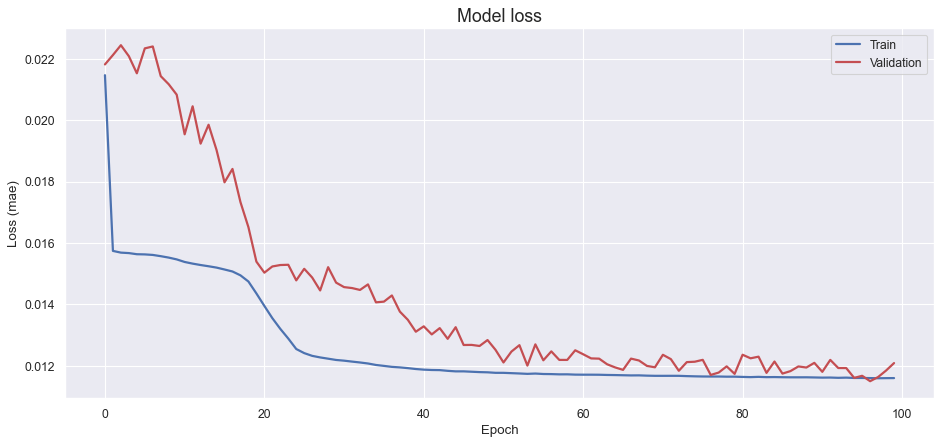

In [15]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

1876/1876 [==============================] - 5s 2ms/step


C:\Users\fondr\AppData\Local\Temp\ipykernel_6696\3806888063.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue')


<AxesSubplot:title={'center':'Loss Distribution'}, xlabel='Loss_mae', ylabel='Density'>

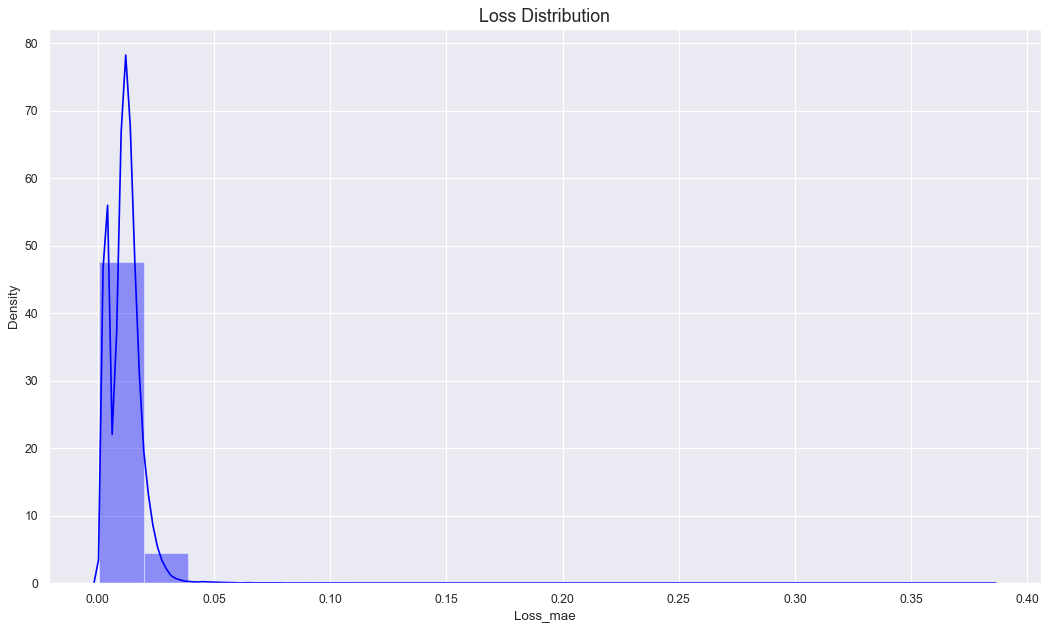

In [16]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue')

In [41]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.05
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored

1238/1238 [==============================] - 3s 3ms/step


,Loss_mae,Threshold,Anomaly
time,,,
2022-08-16 00:00:00,0.016120,0.05,False
2022-08-16 00:01:00,0.011642,0.05,False
2022-08-16 00:02:00,0.014021,0.05,False
2022-08-16 00:03:00,0.011551,0.05,False
2022-08-16 00:05:00,0.008554,0.05,False
...,...,...,...
2022-12-31 18:43:00,0.007998,0.05,False
2022-12-31 19:13:00,0.010127,0.05,False
2022-12-31 22:13:00,0.009759,0.05,False


In [18]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index
scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.05
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

1876/1876 [==============================] - 4s 2ms/step


<AxesSubplot:xlabel='time'>

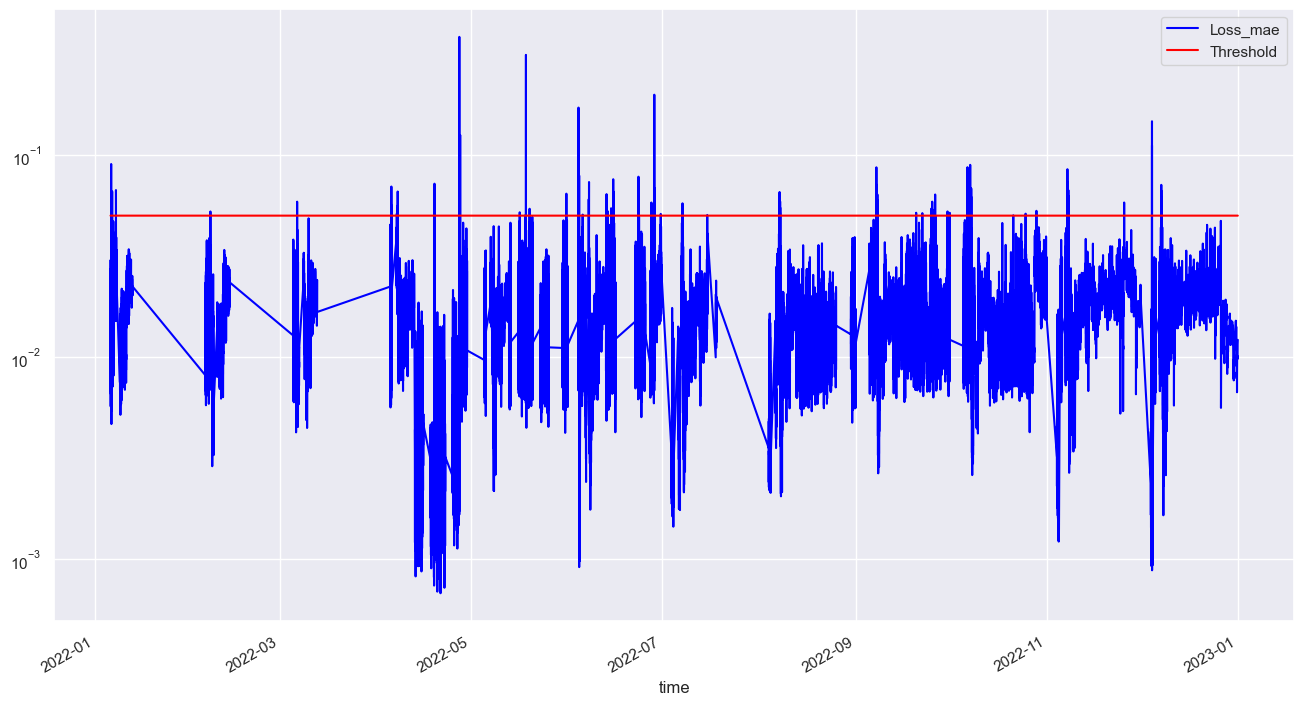

In [19]:
scored.plot(logy=True, figsize=(16,9), color=['blue','red'])

In [20]:
model.save("model.h5")
print("Model saved")

Model saved
